## Uploading to Bucket

In [36]:
# %pip install -U sagemaker
!pip install scikit-learn==1.2.1

ERROR: Ignored the following versions that require a different python version: 1.1.0 Requires-Python >=3.8; 1.1.1 Requires-Python >=3.8; 1.1.2 Requires-Python >=3.8; 1.1.3 Requires-Python >=3.8; 1.2.0 Requires-Python >=3.8; 1.2.0rc1 Requires-Python >=3.8; 1.2.1 Requires-Python >=3.8; 1.2.2 Requires-Python >=3.8
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.2.1 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2)
ERROR: No matching distribution found for scikit-learn==1.2.1


In [4]:
# test commit change
print('hello ronel')

hello ronel


In [3]:
import boto3
import pandas as pd
import numpy as np
import os

# Create an S3 client
s3_client = boto3.client('s3')

# Specify a unique bucket name
bucket_name = 'crisis-detection-bucket-ronel'
prefix = "model"

In [38]:
# Create the S3 bucket
try:
    # Create the S3 bucket
    s3_client.create_bucket(Bucket=bucket_name)
    print("Bucket created successfully!")
except ClientError as e:
    # Check if the error is due to bucket already existing
    error_code = e.response['Error']['Code']
    if error_code == 'BucketAlreadyOwnedByYou':
        print("Bucket already exists. Continuing with the existing bucket.")
    else:
        print("An error occurred while creating the bucket:", error_code)
        raise

Bucket created successfully!


In [5]:
# Read the local file as a DataFrame using pandas
# Specify the local file path and desired S3 object key
local_file_path = 'data.csv'
df = pd.read_csv(local_file_path)
df = df[['target','text']]
df.head()

,target,text
0,1,Our Deeds are the Reason of this #earthquake M...
1,1,Forest fire near La Ronge Sask. Canada
2,1,All residents asked to 'shelter in place' are ...
3,1,"13,000 people receive #wildfires evacuation or..."
4,1,Just got sent this photo from Ruby #Alaska as ...


In [6]:
# Create a sagemaker session to upload data to S3
import sagemaker
from sklearn.model_selection import train_test_split
from sagemaker.inputs import TrainingInput

sagemaker_session = sagemaker.Session()
# batch_1, batch_2 = train_test_split(df, test_size=0.2, random_state=2023)

# Save the train and test datasets to local files
# batch_1.to_csv('batch_1.csv', index=False)
# batch_2.to_csv('batch_2.csv', index=False)
batch_1_input_path = sagemaker_session.upload_data("batch_1.csv", bucket_name, os.path.join('batch_1'))
batch_2_input_path = sagemaker_session.upload_data("batch_2.csv", bucket_name, os.path.join('batch_2'))

print(batch_1_input_path)
print(batch_2_input_path)

s3://crisis-detection-bucket-ronel/batch_1/batch_1.csv
s3://crisis-detection-bucket-ronel/batch_2/batch_2.csv


## Train model
The model is trained using the SageMaker SDK's Estimator class. Firstly, get the execution role for training. This role allows us to access the S3 bucket in the last step, where the train and test data set is located.

In [39]:
# Use the current execution role for training. It needs access to S3
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::703324908811:role/LabRole


Then, it is time to define the SageMaker SDK Estimator class. We use an Estimator class specifically desgined to train scikit-learn models called `SKLearn`. In this estimator, we define the following parameters:
1. The script that we want to use to train the model (i.e. `entry_point`). This is the heart of the Script Mode method. Additionally, set the `script_mode` parameter to `True`.
1. The role which allows us access to the S3 bucket containing the train and test data set (i.e. `role`)
1. How many instances we want to use in training (i.e. `instance_count`) and what type of instance we want to use in training (i.e. `instance_type`)
1. Which version of scikit-learn to use (i.e. `framework_version`)
1. Training hyperparameters (i.e. `hyperparameters`)

After setting these parameters, the `fit` function is invoked to train the model.

In [8]:
# Docs: https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html

from sagemaker.sklearn import SKLearn

# Define the training script and dependencies
train_script = 'train.py'  # Replace with your actual training script name
dependencies = ['utils.py']  # Replace with your required dependencies

# Set up the SKLearn estimator with dependencies
sk_estimator = SKLearn(
    entry_point=train_script,
    dependencies=dependencies,
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version="1.2-1",
    script_mode=True,
    py_version='py3',
    sagemaker_session=sagemaker_session,
    output_path="s3://{}/{}".format(bucket_name, prefix),
    base_job_name= "sagemaker-crisis-detection",
    code_location= "s3://{}/{}".format(bucket_name, "jobs")
    
)

# Train the estimator
print(batch_1_input_path)
s3_input_train = TrainingInput(batch_1_input_path)
sk_estimator.fit({"train": s3_input_train})

INFO:sagemaker:Creating training-job with name: sagemaker-crisis-detection-2023-06-04-05-01-49-586


s3://crisis-detection-bucket-ronel/batch_1/batch_1.csv
2023-06-04 05:01:50 Starting - Starting the training job...
2023-06-04 05:02:05 Starting - Preparing the instances for training...
2023-06-04 05:03:00 Downloading - Downloading input data...
2023-06-04 05:03:25 Training - Downloading the training image...
2023-06-04 05:03:45 Training - Training image download completed. Training in progress.2023-06-04 05:03:50,089 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-06-04 05:03:50,092 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-04 05:03:50,100 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-06-04 05:03:50,290 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-04 05:03:50,300 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-04 05:03:50,311 sagemaker-training-toolkit INFO     No GPUs de

In [9]:
model_data = sk_estimator.model_data
image_uri = sk_estimator.image_uri
model_role = sk_estimator.role

print(f"Model Data: {model_data}\nImage URI: {image_uri}\nModel Role: {model_role}")

# print(sk_estimator.__dict__)


Model Data: s3://crisis-detection-bucket-ronel/model/sagemaker-crisis-detection-2023-06-04-05-01-49-586/output/model.tar.gz
Image URI: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
Model Role: arn:aws:iam::703324908811:role/LabRole


## Trying out Incremental Learning on SageMaker

In [19]:
import joblib
import tarfile

# Download the model tar.gz file from S3
s3_client.download_file('crisis-detection-bucket-ronel', model_data.split('s3://{}/'.format(bucket_name))[1], 'model.tar.gz')

# Extract the model file from the tar.gz archive
with tarfile.open('model.tar.gz', 'r:gz') as tar:
    tar.extractall('.')

# Load the trained model
model = joblib.load('model.joblib')


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator ColumnTransformer from version 1.2.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SGDClassifier from version 1.2.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk

In [17]:
test_data = [
    'This is the first text.', 'This is the second text.',
    'Another text for prediction.', 'One more text to predict.',
    'disaster is imminent', 'omg an earthquake'
]

# Create a DataFrame with the test data and feature names
test_df = pd.DataFrame({'text': test_data})
print(test_df)

# Use the transformed test data in prediction
predictions = model.predict(test_df)

print(predictions)

                           text
0       This is the first text.
1      This is the second text.
2  Another text for prediction.
3     One more text to predict.
4          disaster is imminent
5             omg an earthquake


AttributeError: 'ColumnTransformer' object has no attribute '_feature_names_in'

In [18]:
print(model)

Pipeline(memory=None,
         steps=[('col_transformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('vect',
                                                  TfidfVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.float64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                        

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [84]:
# df2 = pd.read_csv('test_data.csv')
# df2.head()

,target,text
0,0,Having trouble understanding the rotations wit...
1,0,Wow Crackdown 3 uses multiple servers in multi...
2,0,Heart disease prevention: What about secondhan...
3,1,Cape Coral city leaders take part in mock hurr...
4,0,#np Avenged Sevenfold - Hail To The King


In [78]:
# X = df2.drop(['id', 'target', 'keyword','location'], axis=1, errors='ignore')
# y = df2['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, stratify=y)
# X_train = model.named_steps['col_transformer'].transform(X_train)

In [79]:
model.named_steps['clf'].partial_fit(X_train, y_train)

SGDClassifier(loss='log_loss', max_iter=3500, penalty='l1')

In [81]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# y_pred = model.predict(X_test)
# f1 = f1_score(y_test, y_pred, average='binary')
# print('F1 Score: {:.4f}'.format(f1))

F1 Score: 0.6489


In [12]:
# Docs: https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html

from sagemaker.sklearn import SKLearn

# Define the training script and dependencies
incremental_script = 'incremental.py'  # Replace with your actual training script name
dependencies = ['utils.py']  # Replace with your required dependencies

# Set up the SKLearn estimator with dependencies
sk_estimator_incremental = SKLearn(
    entry_point=incremental_script,
    dependencies=dependencies,
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version="1.2-1",
    script_mode=True,
    py_version='py3',
    sagemaker_session=sagemaker_session,
    output_path="s3://{}/{}".format(bucket_name, prefix),
    base_job_name= "sagemaker-crisis-detection",
    code_location= "s3://{}/{}".format(bucket_name, "jobs")
    
)

# Train the estimator
print(batch_2_input_path, model_data)
s3_input_train_incremental = TrainingInput(batch_2_input_path)
sk_estimator_incremental.fit({"train": s3_input_train_incremental})

s3://crisis-detection-bucket/batch_2/batch_2.csv s3://crisis-detection-bucket/model/sagemaker-crisis-detection-2023-05-31-08-35-10-890/output/model.tar.gz
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: sagemaker-crisis-detection-2023-05-31-08-37-54-044


2023-05-31 08:37:54 Starting - Starting the training job...
2023-05-31 08:38:09 Starting - Preparing the instances for training......
2023-05-31 08:39:04 Downloading - Downloading input data...
2023-05-31 08:39:45 Training - Training image download completed. Training in progress.2023-05-31 08:39:47,185 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-05-31 08:39:47,189 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-31 08:39:47,197 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-05-31 08:39:47,405 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-31 08:39:47,417 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-31 08:39:47,428 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-05-31 08:39:47,438 sagemaker-training-toolkit INFO     Invoking user script

In [13]:
model_data_incre = sk_estimator_incremental.model_data
image_uri_incre = sk_estimator_incremental.image_uri
model_role_incre = sk_estimator_incremental.role

print(f"Model Data: {model_data_incre}\nImage URI: {image_uri_incre}\nModel Role: {model_role_incre}")

# print(sk_estimator.__dict__)


Model Data: s3://crisis-detection-bucket/model/sagemaker-crisis-detection-2023-05-31-08-37-54-044/output/model.tar.gz
Image URI: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
Model Role: arn:aws:iam::823616654574:role/LabRole


## Deploy and test serverless endpoint
After training the model, it is time to deploy it as an endpoint. To do so, we invoke the `deploy` function within the scikit-learn estimator. As shown in the code below, one can define the number of instances (i.e. `initial_instance_count`) and instance type (i.e. `instance_type`) used to deploy the model.

In [25]:
from sagemaker.serverless import ServerlessInferenceConfig

# Create an empty ServerlessInferenceConfig object to use default values
serverless_config = ServerlessInferenceConfig()

In [26]:
# Specify MemorySizeInMB and MaxConcurrency in the serverless config object
serverless_config = ServerlessInferenceConfig(
  memory_size_in_mb=1024,
  max_concurrency=10,
)

In [27]:
# sk_predictor = sk_estimator_incremental.deploy(serverless_inference_config=serverless_config)
sk_predictor = sk_estimator.deploy(serverless_inference_config=serverless_config)

INFO:sagemaker:Creating model with name: sagemaker-crisis-detection-2023-06-04-05-43-17-303
INFO:sagemaker:Creating endpoint-config with name sagemaker-crisis-detection-2023-06-04-05-43-17-303
INFO:sagemaker:Creating endpoint with name sagemaker-crisis-detection-2023-06-04-05-43-17-303


-----------------------!

In [32]:
# Create a Boto3 SageMaker client
sagemaker_client = boto3.client('sagemaker')

# List the endpoints
response = sagemaker_client.list_endpoints()

# Iterate through the endpoints and print their names
for endpoint in response['Endpoints']:
    print(endpoint['EndpointName'])


sagemaker-crisis-detection-2023-06-04-05-43-17-303
demo-lambda-deploy-endpoint-06-03-10-23-24


After the endpoint has been completely deployed, it can be invoked using the [SageMaker Runtime Client](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker-runtime.html) (which is the method used in the code cell below) or [Scikit Learn Predictor](https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html#scikit-learn-predictor). If you plan to use the latter method, make sure to use a [Serializer](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) to serialize your data properly.

In [29]:
import json

client = sagemaker_session.sagemaker_runtime_client

# Define the input data in the desired format
input_data = {"Input": ["This is a disaster","Hello world"]}

# Convert the input data to JSON payload
payload = json.dumps(input_data)

# Invoke the endpoint to get the prediction
response = client.invoke_endpoint(
    EndpointName='sagemaker-crisis-detection-2023-06-04-05-43-17-303',
    ContentType='application/json',
    Body=payload
)

# Parse the prediction response
response_body = response['Body'].read().decode('utf-8')
prediction_result = json.loads(response_body)['Output']
print(response_body)


{"Output":[1,0],"Probabilities":[[0.14113806243937366,0.8588619375606263],[0.6561498682557771,0.3438501317442229]]}



## Cleanup
If the model and endpoint are no longer in use, they should be deleted to save costs and free up resources.

In [33]:
for endpoint in response['Endpoints']:
    endpoint_name = endpoint['EndpointName']
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"Deleted endpoint: {endpoint_name}")

Deleted endpoint: sagemaker-crisis-detection-2023-06-04-05-43-17-303
Deleted endpoint: demo-lambda-deploy-endpoint-06-03-10-23-24


In [31]:
response['Endpoints']

KeyError: 'Endpoints'

In [ ]:
# sk_predictor.delete_model()
# sk_predictor.delete_endpoint()

In [147]:
# import boto3

# # Specify the endpoint name to delete
# endpoint_name = 'sklearn-rf-model2023-05-20-09-06-08'

# # Create a SageMaker client
# sagemaker_client = boto3.client('sagemaker')

# # Delete the endpoint
# sagemaker_client.delete_endpoint(EndpointName=endpoint_name)


### Reloading pretrained model

In [ ]:
import sagemaker

# Define the training script and dependencies
role = sagemaker.get_execution_role()

sagemaker_session = sagemaker.Session()

In [23]:
batch_1_input_path = 's3://crisis-detection-bucket-ronel/batch_1/batch_1.csv'

In [25]:
# Docs: https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/sagemaker.sklearn.html

from sagemaker.inputs import TrainingInput
from sagemaker.sklearn import SKLearn

# Define the training script and dependencies
train_script = 'train.py'  # Replace with your actual training script name
dependencies = ['utils.py']  # Replace with your required dependencies

# Set up the SKLearn estimator with dependencies
sk_estimator = SKLearn(
    entry_point=train_script,
    dependencies=dependencies,
    role=role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version="1.2-1",
    script_mode=True,
    py_version='py3',
    sagemaker_session=sagemaker_session,
    output_path="s3://{}/{}".format(bucket_name, prefix),
    base_job_name= "sagemaker-crisis-detection",
    code_location= "s3://{}/{}".format(bucket_name, "jobs")
    
)

# Train the estimator
print(batch_1_input_path)
s3_input_train = TrainingInput(batch_1_input_path)
sk_estimator.fit({"train": s3_input_train})

INFO:sagemaker:Creating training-job with name: sagemaker-crisis-detection-2023-06-06-15-34-32-550


s3://crisis-detection-bucket-ronel/batch_1/batch_1.csv
Using provided s3_resource
2023-06-06 15:34:32 Starting - Starting the training job...
2023-06-06 15:34:55 Starting - Preparing the instances for training......
2023-06-06 15:35:55 Downloading - Downloading input data...
2023-06-06 15:36:30 Training - Downloading the training image..
2023-06-06 15:37:01 Uploading - Uploading generated training model2023-06-06 15:36:42,666 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-06-06 15:36:42,669 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-06 15:36:42,677 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-06-06 15:36:42,903 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-06 15:36:42,915 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-06 15:36:42,927 sagemaker-training-toolkit INFO     No

In [27]:

from sagemaker.serverless import ServerlessInferenceConfig

# Create an empty ServerlessInferenceConfig object to use default values
serverless_config = ServerlessInferenceConfig()

# Specify MemorySizeInMB and MaxConcurrency in the serverless config object
serverless_config = ServerlessInferenceConfig(
  memory_size_in_mb=1024,
  max_concurrency=10,
)

sk_predictor = sk_estimator.deploy(serverless_inference_config=serverless_config)

INFO:sagemaker:Creating model with name: sagemaker-crisis-detection-2023-06-06-15-38-20-884
INFO:sagemaker:Creating endpoint-config with name sagemaker-crisis-detection-2023-06-06-15-38-20-884
INFO:sagemaker:Creating endpoint with name sagemaker-crisis-detection-2023-06-06-15-38-20-884


----!

In [28]:
# Create a Boto3 SageMaker client
sagemaker_client = boto3.client('sagemaker')

# List the endpoints
response = sagemaker_client.list_endpoints()

# Iterate through the endpoints and print their names
for endpoint in response['Endpoints']:
    print(endpoint['EndpointName'])

sagemaker-crisis-detection-2023-06-06-15-38-20-884


In [30]:
endpoint_name = 'sagemaker-crisis-detection-2023-06-06-15-38-20-884'


### Call Model

In [135]:
import json

def call_model(input_data):
    
    client = sagemaker_session.sagemaker_runtime_client

    # Convert the input data to JSON payload
    payload = json.dumps(input_data)

    # Invoke the endpoint to get the prediction
    response = client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=payload
    )

    # Parse the prediction response
    response_body = response['Body'].read().decode('utf-8')
    prediction_result = json.loads(response_body)['Output']

    
    # download initial data
    s3_client.download_file('crisis-detection-bucket-ronel', 'scored_data/scored_data.csv', 'scored_data.csv')
    scored_data = pd.read_csv('scored_data.csv')


    # append new data
    scored_data = pd.concat([scored_data,
                             pd.DataFrame({'prediction':json.loads(response_body)['Output'], 
                                                'probability':[i[1] for i in json.loads(response_body)['Probabilities']],
                                                'input_data': input_data['Input'],
                                                'timestamp':timestamp
                                                })],
                             ignore_index=True)

    scored_data.to_csv('scored_data.csv', index=False)
    
    # upload new data
    scored_data_s3 = sagemaker_session.upload_data("scored_data.csv", bucket_name, os.path.join('scored_data'))
    
    # plot tweets
    plot_tweets(scored_data)

### Plot Tweets

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_tweets(df):

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date_min'] = df['timestamp'].dt.round('min')

    # Plot a smooth line of the sum of positive predictions with seaborn
    plt.figure(figsize=(20,10))
    sns.lineplot(x='date_min', y='prediction', data=df, estimator=sum)

    # Axis labels
    plt.xlabel('Date')
    plt.ylabel('Number of flagged tweets')
    plt.show()

### Simulate Model Inference Every Minute

In [154]:
# simply reusing the data to test model inference
import time 
from datetime import datetime

local_file_path = 'data.csv'
df = pd.read_csv(local_file_path, usecols=['text'])

Minute: 1


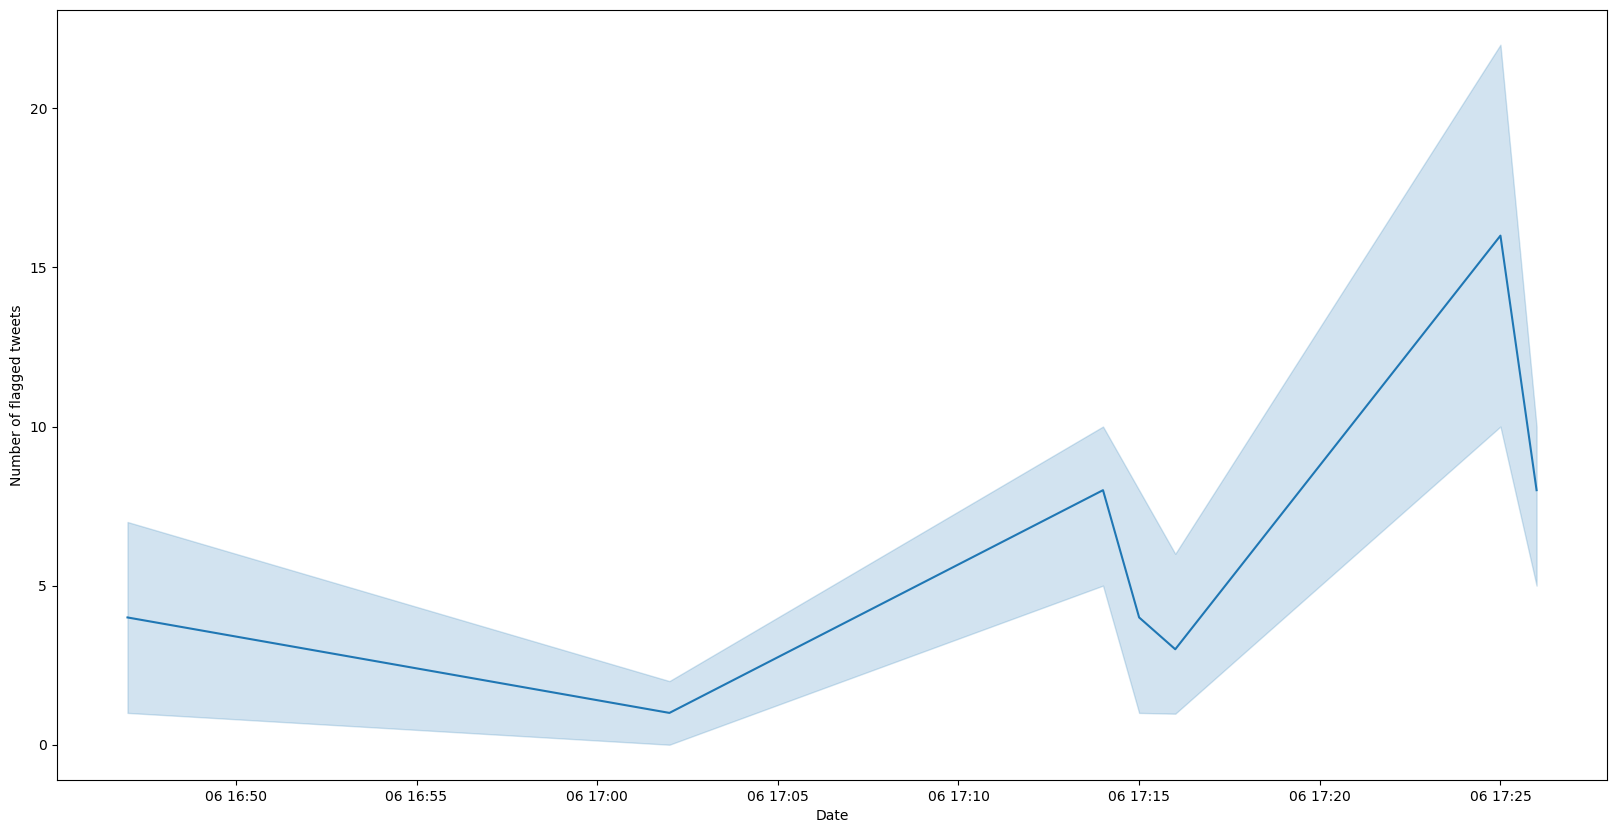

Minute: 2


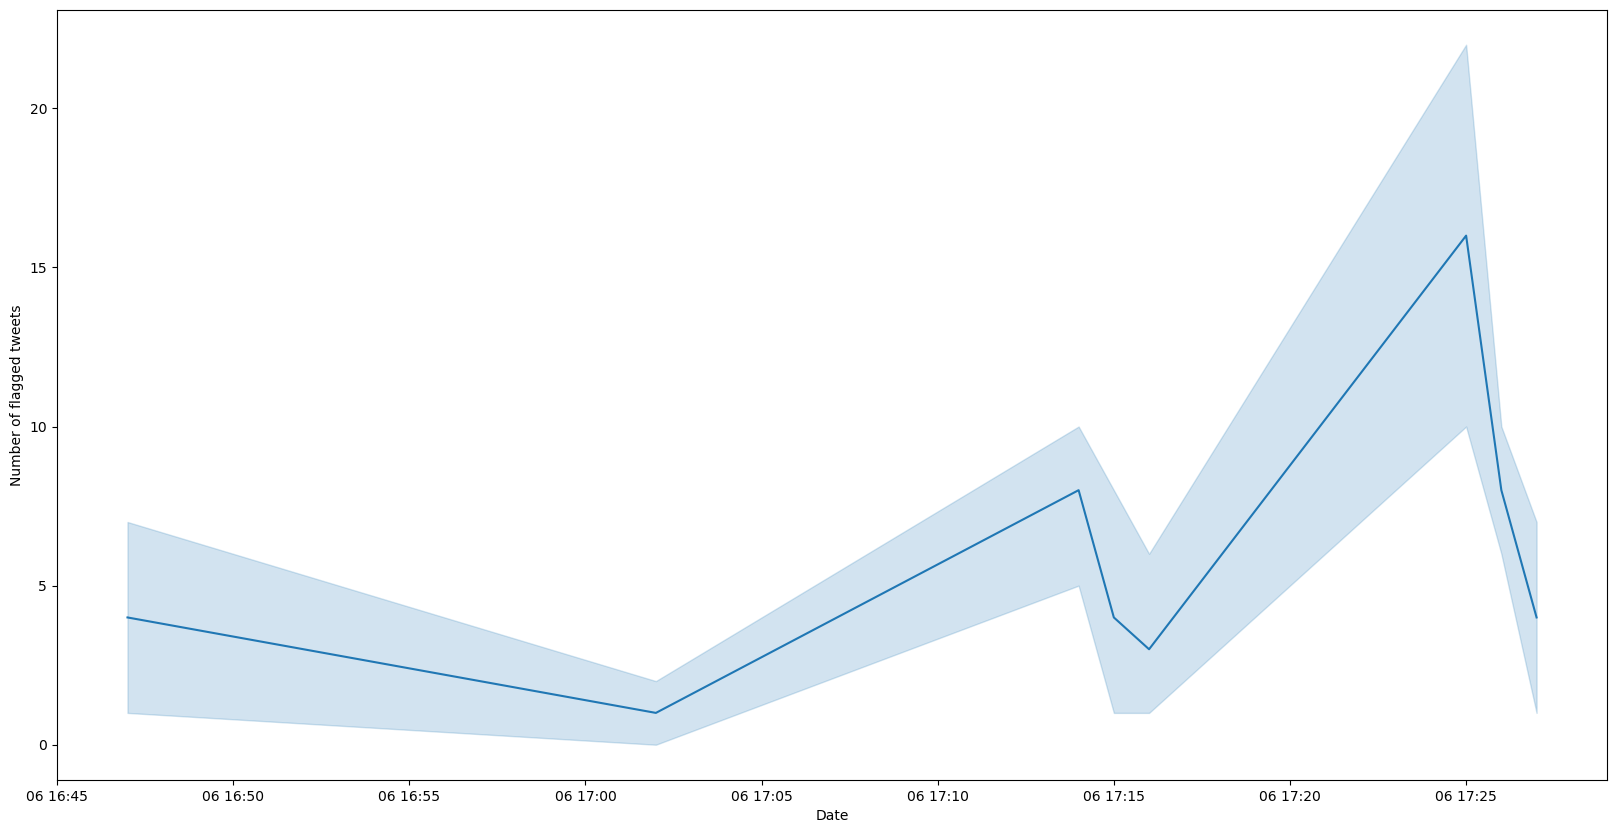

Minute: 3


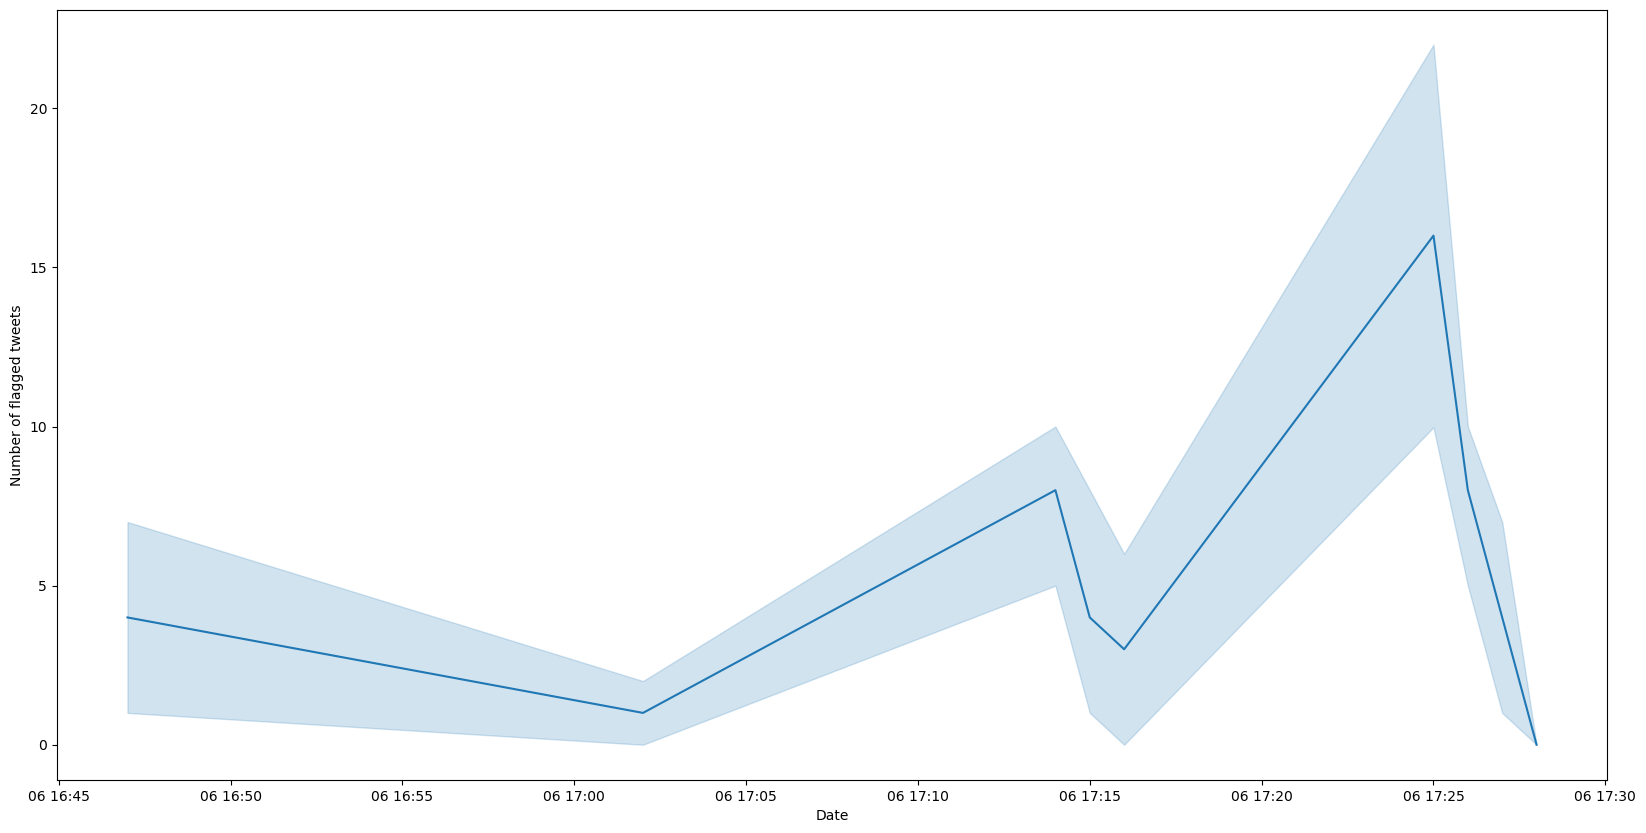

Minute: 4


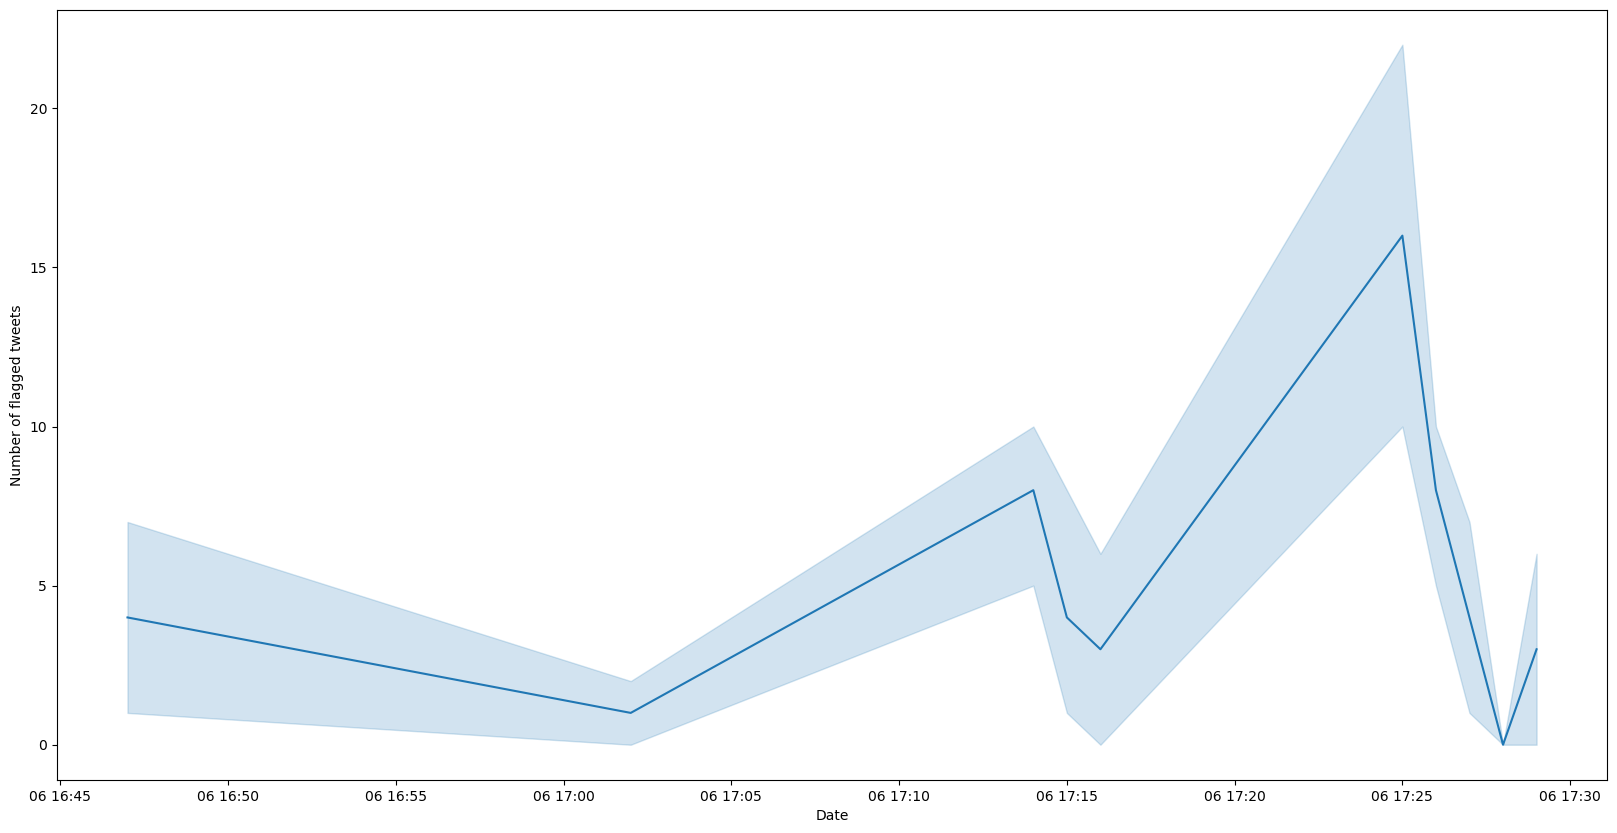

Minute: 5


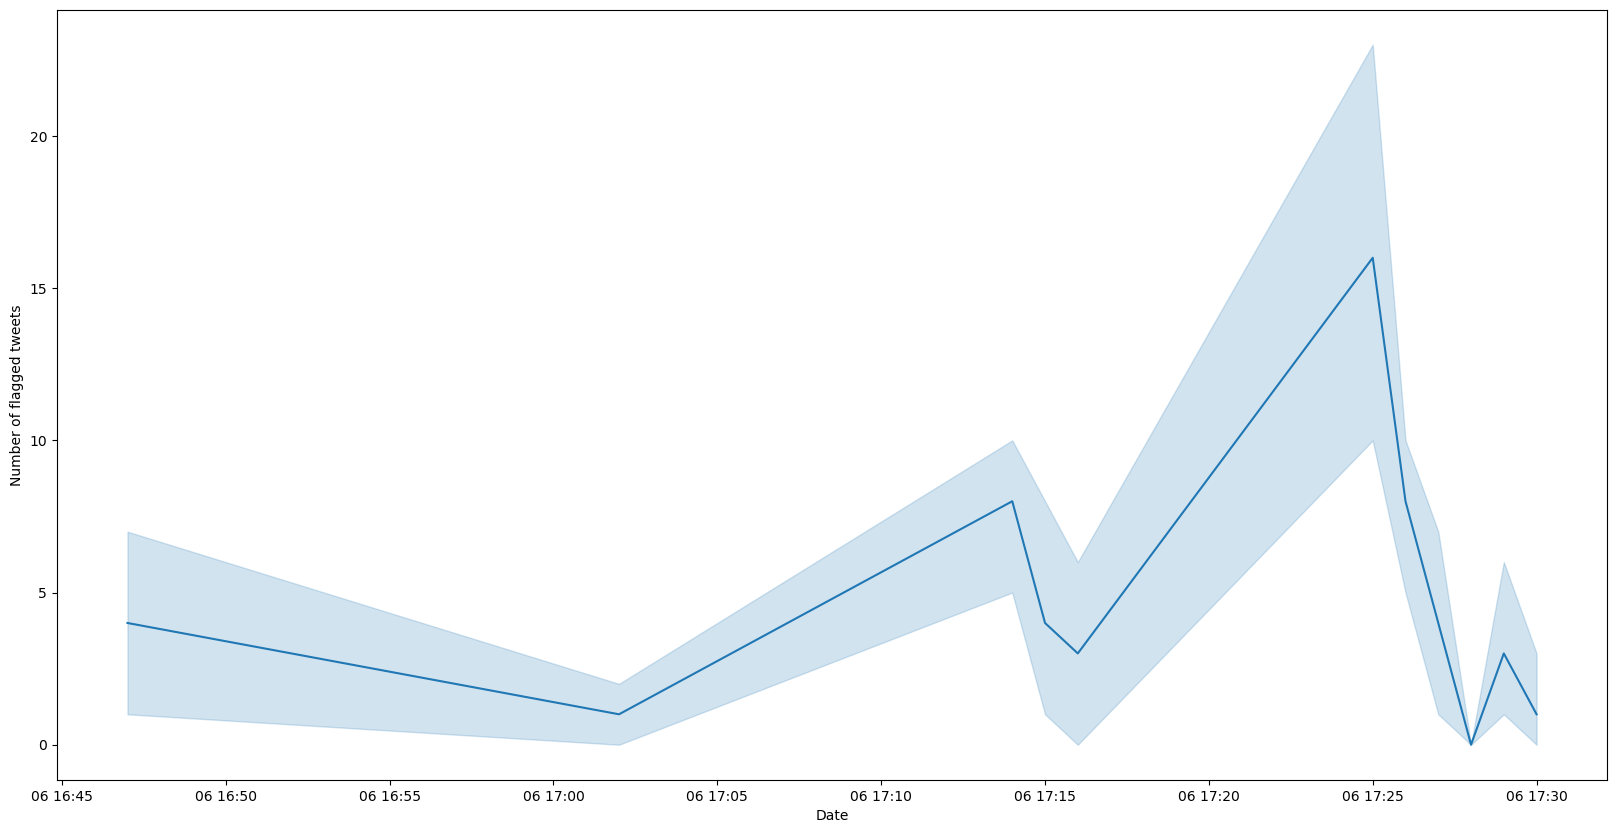

Minute: 6


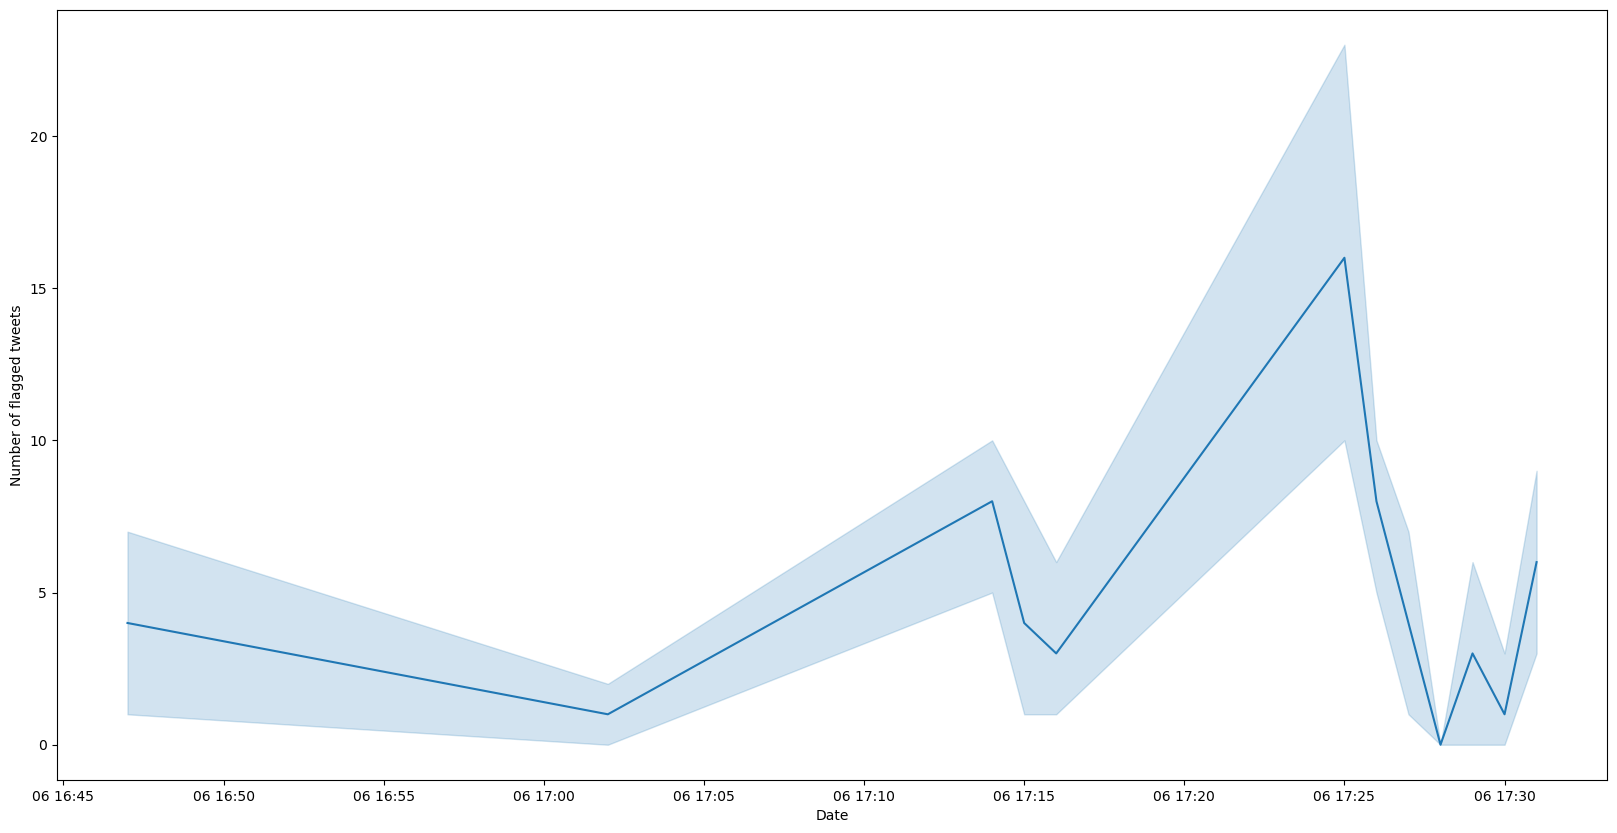

Minute: 7


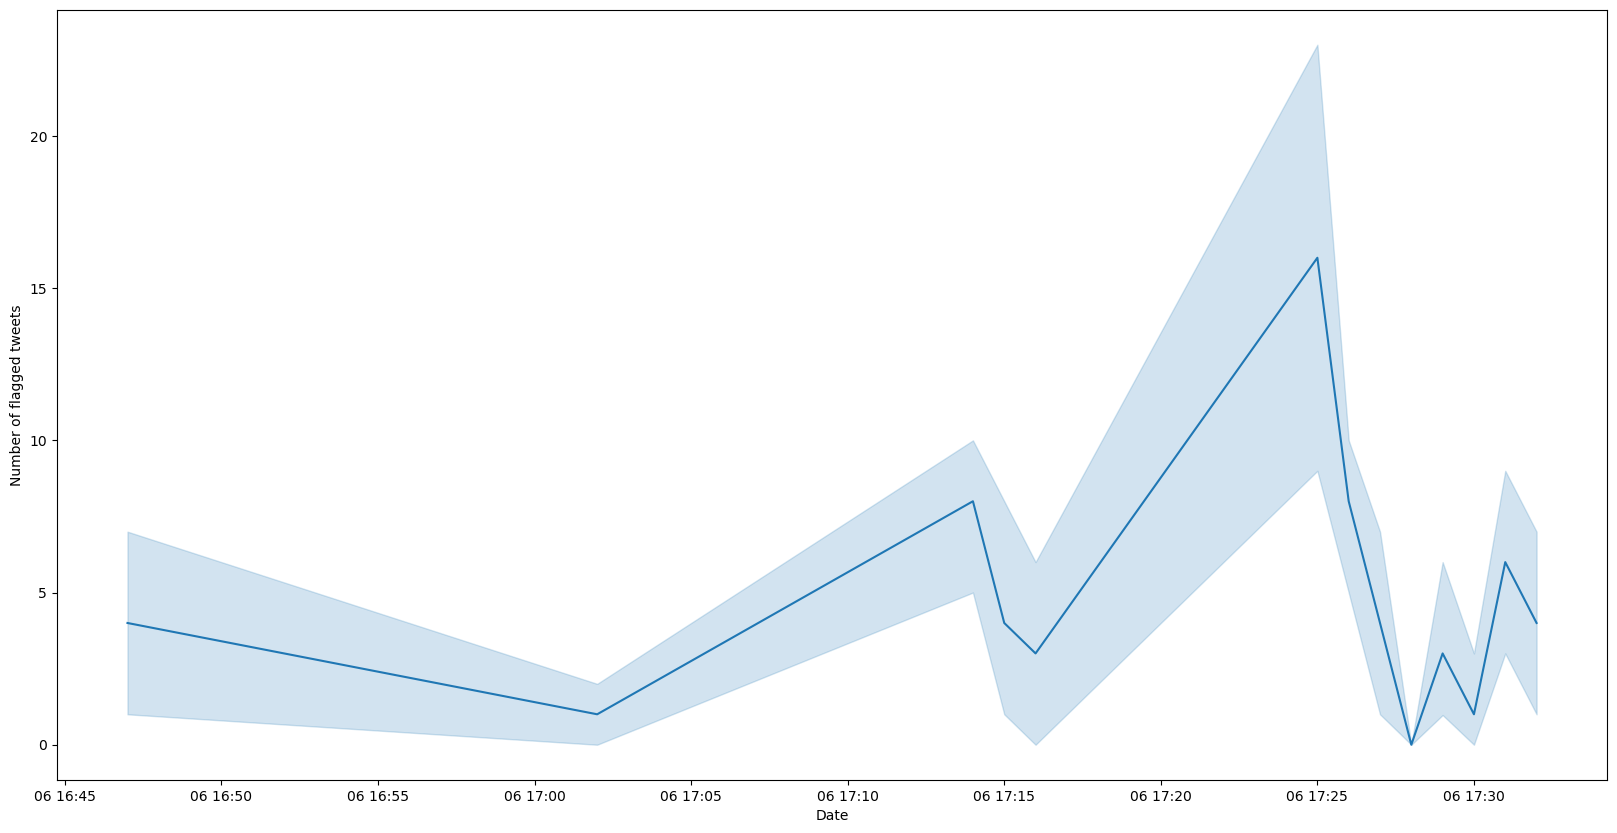

Minute: 8


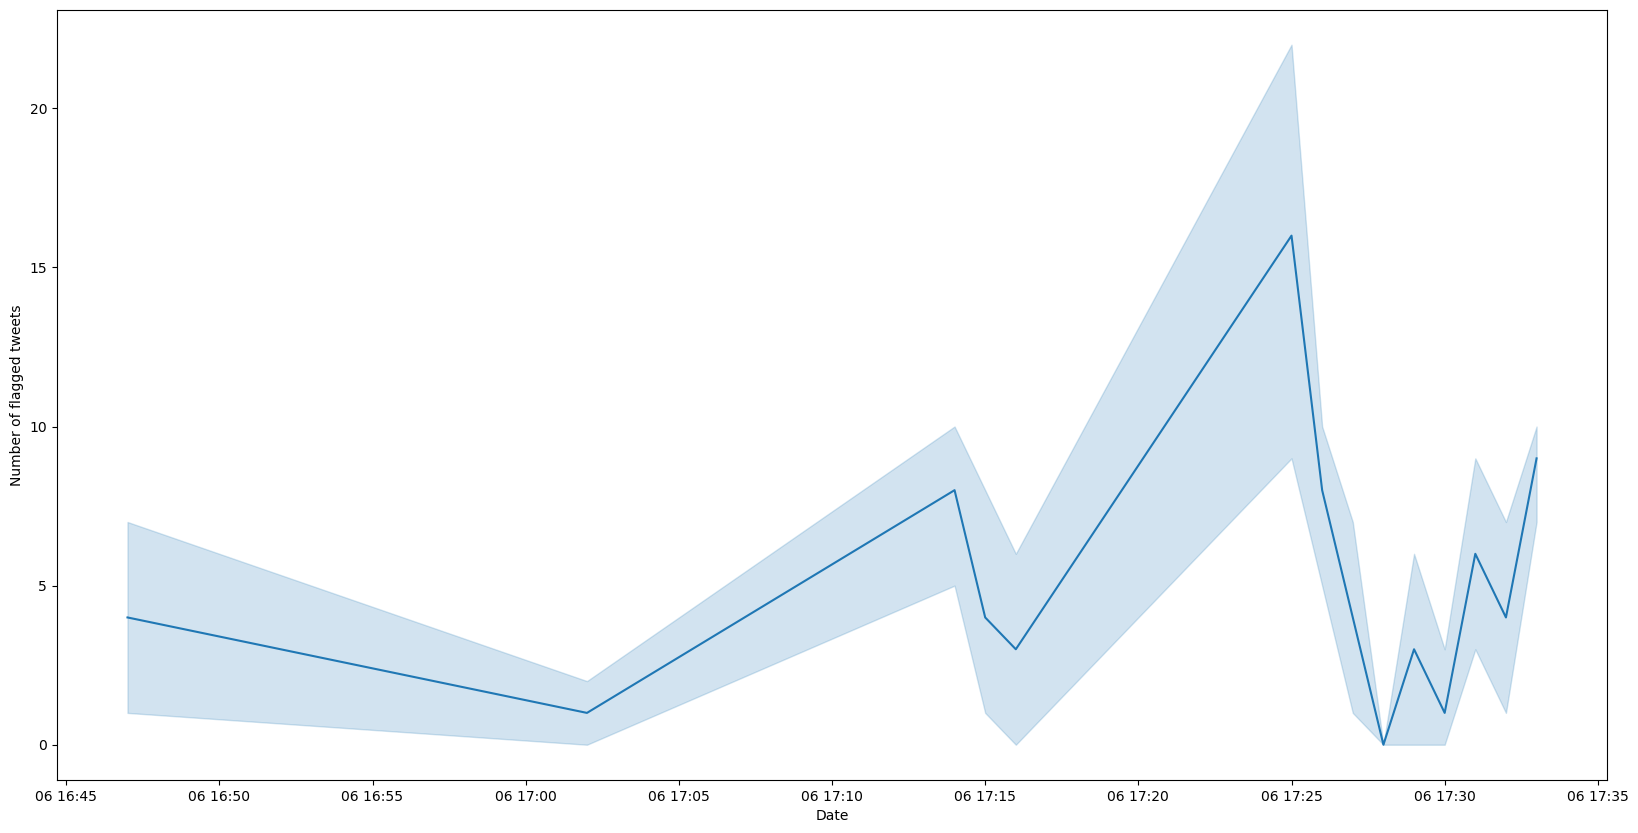

KeyboardInterrupt: 

In [156]:
# simulate streaming every minute

ctr=0
while True:
    # Code executed here
    
    
    print("Minute: {}".format(ctr+1))

    input_data={}
    input_data['Input']= df['text'].values.tolist()[ctr*10:(ctr+1)*10]
    
    str_date_now = str(datetime.now())
    timestamp = [str_date_now for i in range(len(input_data['Input']))]

    call_model(input_data)
    ctr+=1
    
    time.sleep(60)